In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [26]:
%load_ext autoreload
%autoreload 2
from datasets import load_dataset, DatasetDict
import evaluate

import torch
import torch.nn as nn
import torch.nn.functional as F
from safetensors.torch import load_file

import math
import numpy as np

from dataclasses import dataclass

from transformers import Trainer, TrainingArguments, AutoTokenizer, DataCollatorForLanguageModeling

from huggingface_hub import notebook_login

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
tokenizer = AutoTokenizer.from_pretrained("unsloth/Meta-Llama-3.1-8B-Instruct")

In [28]:
@dataclass
class Config:
    d_model: int = 512
    d_ff: int = 2048
    n_heads: int = 8
    vocab_size: int = len(tokenizer)

In [30]:
class PositionalEmbedding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """

        x = x + self.pe[:x.size(1)].unsqueeze(0)
        return self.dropout(x)

class LayerAttention(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.n_heads = config.n_heads

        assert config.d_model % self.n_heads == 0, "d_model should be divisible by n_heads"

        self.d_k = config.d_model // self.n_heads

        self.w_q = nn.Linear(config.d_model, config.d_model)
        self.w_k = nn.Linear(config.d_model, config.d_model)
        self.w_v = nn.Linear(config.d_model, config.d_model)
        self.w_o = nn.Linear(config.d_model, config.d_model)

    def forward(self, query, key, value, attention_mask=None, return_attn=False):
        bs, seq_len = query.size(0), query.size(1)
        
        # Q, K, V
        q = self.w_q(query)
        k = self.w_k(key)
        v = self.w_v(value)
    
        q = q.view(bs, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        k = k.view(bs, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        v = v.view(bs, seq_len, self.n_heads, self.d_k).transpose(1, 2)
    
        # QK^T
        qk = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
    
        # === MASKING ===
        causal_mask = torch.tril(torch.ones(seq_len, seq_len, device=query.device)).bool()
        causal_mask = ~causal_mask  # True = запрет
        causal_mask = causal_mask.unsqueeze(0).unsqueeze(0)  # [1, 1, seq_len, seq_len]
    
        if attention_mask is not None:
            pad_mask = attention_mask.unsqueeze(1).unsqueeze(2) == 0  # [batch, 1, 1, seq_len]
            full_mask = pad_mask | causal_mask
        else:
            full_mask = causal_mask
    
        qk = qk.masked_fill_(full_mask, torch.finfo(qk.dtype).min)
    
        # === ATTENTION ===
        attn_scores = qk.softmax(-1)
        attn_values = attn_scores @ v
        output = attn_values.transpose(1, 2).reshape(bs, seq_len, -1)
        output = self.w_o(output)
    
        if return_attn:
            return output, attn_scores
        return output




class AtAtModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.d_model)
        self.attn1 = LayerAttention(config)
        self.attn2 = LayerAttention(config)
        self.unembed = nn.Linear(config.d_model, config.vocab_size)
        self.criterion = nn.CrossEntropyLoss()
        self.pe = PositionalEmbedding(config.d_model)

    def get_attention(self, input_ids, attention_mask=None):
        x = self.pe(self.embed(input_ids))
        x1, attn1 = self.attn1(x, x, x, attention_mask, return_attn=True)
        x2, attn2 = self.attn2(x + x1, x + x1, x + x1, attention_mask, return_attn=True)
        return attn1, attn2

    def forward(self, input_ids, labels, attention_mask=None):
        x = self.embed(input_ids)  # [bs, seq, d_model]
        x = self.pe(x)
        x = x + self.attn1(x, x, x, attention_mask)
        x = x + self.attn2(x, x, x, attention_mask)
        x = x.contiguous()
        logits = self.unembed(x).transpose(1, 2)  # [bs, vocab, seq]
        shift_logits = logits[..., :-1].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss = self.criterion(shift_logits, shift_labels)
        return {'loss': loss, 'logits': logits}



class CoAtModel(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.embed = nn.Embedding(config.vocab_size, config.d_model)
        self.conv = nn.Conv1d(
            in_channels=config.d_model,
            out_channels=config.d_model,
            kernel_size=3,
            bias=False
        )
        self.attn = LayerAttention(config)
        self.unembed = nn.Linear(config.d_model, config.vocab_size)
        self.criterion = nn.CrossEntropyLoss()
        self.pe = PositionalEmbedding(config.d_model)

    def forward(self, input_ids, labels, attention_mask=None):
        x = self.embed(input_ids)          # [bs, seq, d_model]
        x = self.pe(x)
        x = x.transpose(1, 2)              # [bs, d_model, seq]
        x = F.pad(x, (2, 0))               # causal padding for kernel=3
        x = self.conv(x)                   # [bs, d_model, seq]
        x = x.transpose(1, 2)              # [bs, seq, d_model]

        x = x + self.attn(x, x, x, attention_mask)
        x = x.contiguous()
        logits = self.unembed(x).transpose(1, 2)
        shift_logits = logits[..., :-1].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        loss = self.criterion(shift_logits, shift_labels)
        return {'loss': loss, 'logits': logits}



config = Config()

atat_model = AtAtModel(config)
coat_model = CoAtModel(config)

In [31]:
state_dict = load_file("co-at-pretrain-v3/checkpoint-450000/model.safetensors")
coat_model.load_state_dict(state_dict)

<All keys matched successfully>

In [33]:
state_dict = load_file("at-at-pretrain-owt-v3.1/checkpoint-500000/model.safetensors")
atat_model.load_state_dict(state_dict)

<All keys matched successfully>

In [34]:
state_dict.keys()

dict_keys(['attn1.w_k.bias', 'attn1.w_k.weight', 'attn1.w_o.bias', 'attn1.w_o.weight', 'attn1.w_q.bias', 'attn1.w_q.weight', 'attn1.w_v.bias', 'attn1.w_v.weight', 'attn2.w_k.bias', 'attn2.w_k.weight', 'attn2.w_o.bias', 'attn2.w_o.weight', 'attn2.w_q.bias', 'attn2.w_q.weight', 'attn2.w_v.bias', 'attn2.w_v.weight', 'embed.weight', 'pe.pe', 'unembed.bias', 'unembed.weight'])

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
coat_model.to(device)
atat_model.to(device)

AtAtModel(
  (embed): Embedding(128256, 512)
  (attn1): LayerAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (w_o): Linear(in_features=512, out_features=512, bias=True)
  )
  (attn2): LayerAttention(
    (w_q): Linear(in_features=512, out_features=512, bias=True)
    (w_k): Linear(in_features=512, out_features=512, bias=True)
    (w_v): Linear(in_features=512, out_features=512, bias=True)
    (w_o): Linear(in_features=512, out_features=512, bias=True)
  )
  (unembed): Linear(in_features=512, out_features=128256, bias=True)
  (criterion): CrossEntropyLoss()
  (pe): PositionalEmbedding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [37]:
text = """Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they were perfectly normal, thank you very much. They were the last people you’d expect to be involved in anything strange or mysterious, because they just didn’t hold with such nonsense.

Mr Dursley was the director of a firm called Grunnings, which made drills. He was a big, beefy man with hardly any neck, although he did have a very large moustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of neck, which came in very useful as she spent so much of her time craning over garden fences, spying on the neighbours."""

In [38]:
tokens = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
input_ids = tokens.input_ids.to(device)
attention_mask = tokens.attention_mask.to(device)

In [39]:
def get_attn_scores(model):
    with torch.no_grad():
        x = model.embed(input_ids)
        x = x.transpose(1, 2)
        x = F.pad(x, (2, 0))
        x = model.conv(x)
        x = x.transpose(1, 2)
    
        x, attn_scores = model.attn(x, x, x, return_attn=True)
    return x, attn_scores

In [40]:
x, attn_scores = get_attn_scores(coat_model)

In [41]:
tokens_str = tokenizer.convert_ids_to_tokens(input_ids[0])
tokens_str[:10]

['<|begin_of_text|>',
 'Mr',
 'Ġand',
 'ĠMrs',
 'ĠD',
 'urs',
 'ley',
 ',',
 'Ġof',
 'Ġnumber']

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_attention_map(attn_matrix, tokens, head=0):
    """
    attn_matrix: [n_heads, seq_len, seq_len]
    tokens: список токенов
    """
    attn = attn_matrix[head].detach().cpu().numpy()
    seq_len = len(tokens)
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn[:seq_len, :seq_len], xticklabels=tokens, yticklabels=tokens, cmap="viridis")
    plt.title(f"Attention Map - Head {head}")
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


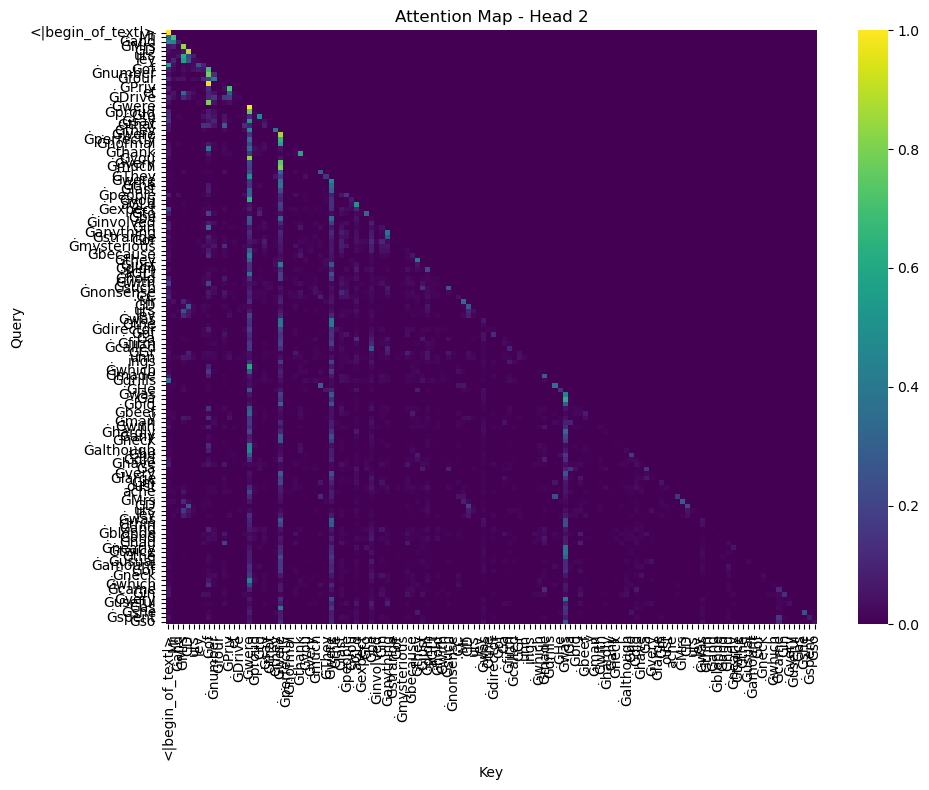

In [43]:
plot_attention_map(attn_scores[0], tokens_str, head=2)


In [44]:
from circuitsvis.attention import attention_patterns

In [45]:
attn_scores = attn_scores[0]  # берем 1-й пример
attn_scores = attn_scores.detach().cpu()

# Приводим к [num_layers, num_heads, seq_len, seq_len]
# В твоем случае возможно только 1 слой → нужно добавить ось
attn_tensor = attn_scores.unsqueeze(0)  # shape: [1, n_heads, seq_len, seq_len]

# Токены
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

In [46]:
attn_tensor = attn_tensor.squeeze(0)
attn_tensor.shape

torch.Size([8, 128, 128])

In [47]:
tokens = [token.replace("Ġ", " ") for token in tokens]
tokens[:10]

['<|begin_of_text|>',
 'Mr',
 ' and',
 ' Mrs',
 ' D',
 'urs',
 'ley',
 ',',
 ' of',
 ' number']

In [48]:
attention_patterns(
    tokens=tokens,
    attention=attn_tensor
)


In [49]:
with torch.no_grad():
    attn1, attn2 = atat_model.get_attention(input_ids.to(atat_model.embed.weight.device), attention_mask.to(atat_model.embed.weight.device))

In [50]:
# Конвертация в нужный формат: [layers, heads, seq, seq]
attn_stack = torch.stack([attn1[0], attn2[0]], dim=0)  # [2, heads, seq, seq]

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
attention_patterns(tokens=tokens, attention=attn_stack.reshape(-1, 128, 128))

In [43]:
def generate_repeated_tokens_from_text(text, tokenizer, device="cuda"):
    tokens = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=64,
    )["input_ids"].to(device)

    bos_token_id = tokenizer.bos_token_id or tokenizer.cls_token_id or tokenizer.pad_token_id or 0
    bos = torch.tensor([[bos_token_id]], device=device)

    repeated = torch.cat([tokens, tokens], dim=-1)[:, :128]  # ensure ≤128
    return repeated


In [44]:
def run_and_cache_model_repeated_tokens(model, tokenizer, text):
    input_ids = generate_repeated_tokens_from_text(text, tokenizer, device=next(model.parameters()).device)
    attention_mask = torch.ones_like(input_ids)

    model.eval()
    with torch.no_grad():
        if hasattr(model, "get_attention"):
            attn = model.get_attention(input_ids, attention_mask)
        else:
            raise ValueError("Модель не имеет метода get_attention()")

        output = model(input_ids, labels=input_ids, attention_mask=attention_mask)
        logits = output["logits"]

    return input_ids, logits, attn


In [45]:
input_ids, logits, attn_layers = run_and_cache_model_repeated_tokens(atat_model, tokenizer, text)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

if isinstance(attn_layers, tuple) or isinstance(attn_layers, list):
    stacked_attn = torch.stack([attn[0] for attn in attn_layers], dim=0)
else:
    stacked_attn = attn_layers  # [1, heads, seq, seq]

In [46]:
stacked_attn.shape

torch.Size([2, 8, 128, 128])

In [47]:
attention_patterns(tokens=tokens, attention=stacked_attn[0, ...])

In [48]:
attention_patterns(tokens=tokens, attention=stacked_attn[1, ...])

In [49]:
conv_weights = coat_model.conv.weight.data.cpu().numpy()
print(conv_weights.shape)  # Ожидается (d_model, d_model, kernel_size)


(512, 512, 3)


In [50]:
# Усредним по оси входных каналов (axis=1), получим матрицу [d_model, kernel_size]
avg_weights = conv_weights.mean(axis=1)


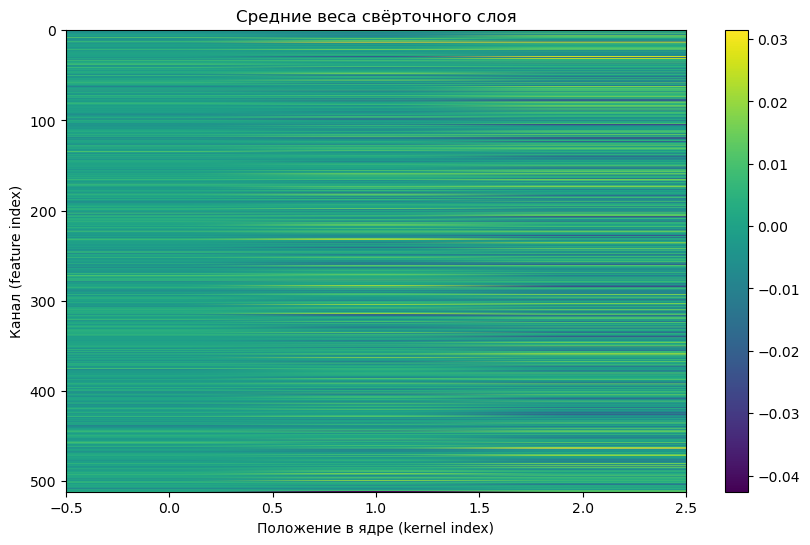

In [51]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
plt.imshow(avg_weights, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Средние веса свёрточного слоя")
plt.xlabel("Положение в ядре (kernel index)")
plt.ylabel("Канал (feature index)")
plt.show()
